# GSoC 2023 ML4SCI QML-HEP Tasks

Marçal Comajoan Cara

## Task VIII: Vision Transformer / Quantum Vision Transformer

### Task statement


- Implement a classical Vision transformer and apply it to MNIST.
- Show its performance on the test data.
- Comment on potential ideas to extend this classical vision transformer architecture to a quantum vision transformer and sketch out the architecture in detail.

---

### Introduction

To understand vision transformers, it is essential to first grasp the concept of transformers. The transformer architecture was introduced in 2017 by Vaswani et al. in the paper "Attention is All You Need" [1]. It revolutionized the field of NLP by providing an efficient and powerful mechanism called self-attention, which allows the model to weigh the importance of different parts of the input sequence in relation to each other. This mechanism enables transformers to capture long-range dependencies and contextual information more effectively than traditional recurrent neural networks (RNNs) or convolutional neural networks (CNNs).

In the context of computer vision, vision transformers were introduced by Dosovitskiy et al. in the paper "An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale" [2]. They treat images as sequences of patches, rather than using the standard convolutional approach. The image is divided into fixed-size, non-overlapping patches, and each patch is linearly embedded into a flat vector. These vectors are then processed by the transformer layers, which consist of multi-head self-attention mechanisms and feed-forward networks. By doing so, the vision transformer can capture both local and global contextual information, resulting in improved performance on various computer vision tasks.

The following figure from the original paper shows an overview of the parts that conform the vision transformer:

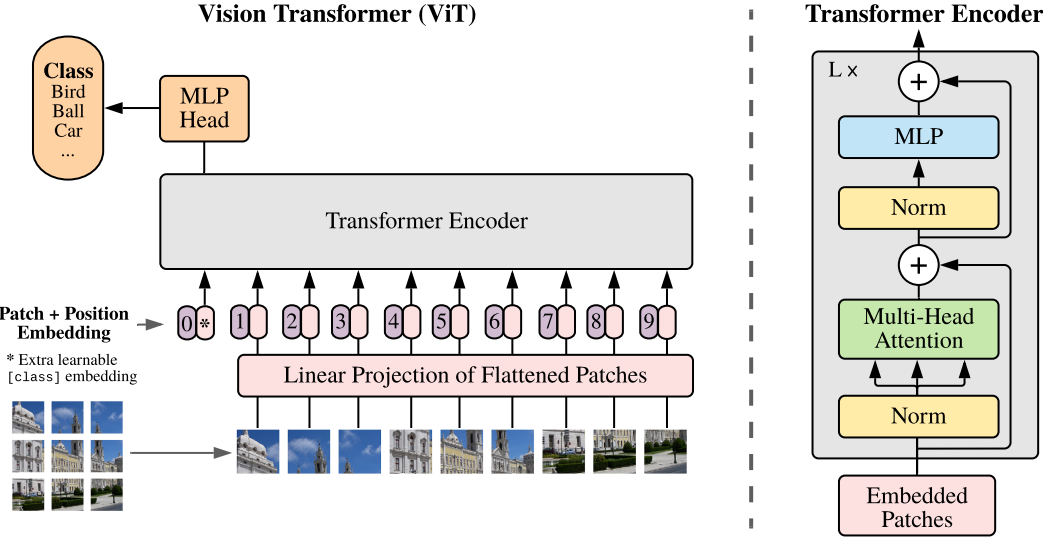

In this notebook I will implement the vision transformer as described in its seminal paper using the PyTorch library [4] to classify the MNIST data set. I will also use Ray Tune [5] to perform hyperparameter optimization using the Bayesian optimization and Hyperband (BOHB) method [6] for improved accuracy.

In [1]:
import os

import numpy as np

import torch
import torch.nn as nn
from torchvision import datasets, transforms

import ray
from ray import air, tune
from ray.air import session
from ray.tune.schedulers.hb_bohb import HyperBandForBOHB
from ray.tune.search.bohb import TuneBOHB

datasets_dir = os.path.expanduser("~/datasets")

### Vision Transformer definition

The code is based on the original code published in [3], which I adapted from JAX to PyTorch.

In [3]:
class SelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.0):
        super().__init__()
        self.multihead_attention = nn.MultiheadAttention(embed_dim, num_heads, dropout, batch_first=True)

    def forward(self, key):
        return self.multihead_attention(key, key, key, need_weights=False)[0]  # self-attention


class TransformerBlock(nn.Module):
    def __init__(self, hidden_size, num_heads, mlp_hidden_size, dropout):
        super().__init__()
        
        self.attention_block = nn.Sequential(
                nn.LayerNorm(hidden_size),
                SelfAttention(hidden_size, num_heads, dropout),
                nn.Dropout(dropout)
        )

        self.mlp_block = nn.Sequential(
                nn.LayerNorm(hidden_size),
                nn.Linear(hidden_size, mlp_hidden_size),
                nn.GELU(),
                nn.Dropout(dropout),
                nn.Linear(mlp_hidden_size, hidden_size),
                nn.Dropout(dropout)
        )


    def forward(self, x):
        x = x + self.attention_block(x)
        y = self.mlp_block(x)
        return x + y


class VisionTransformer(nn.Module):
    def __init__(self, img_size, num_channels, num_classes, patch_size, hidden_size, num_heads, num_transformer_blocks, mlp_hidden_size,
                             dropout=0.1):
        super().__init__()

        # Splitting an image into patches and linearly projecting these flattened patches can be
        # simplified as a single convolution operation, where both the kernel size and the stride size
        # are set to the patch size.
        self.patch_embedding = nn.Conv2d(
            in_channels=num_channels,
            out_channels=hidden_size,
            kernel_size=patch_size,
            stride=patch_size
        )
        num_patches = (img_size // patch_size)**2

        self.cls_token = nn.Parameter(torch.zeros(1, 1, hidden_size))
        num_steps = 1 + num_patches

        self.pos_embedding = nn.Parameter(torch.randn(1, num_steps, hidden_size) * 0.02)
        self.dropout = nn.Dropout(dropout)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(hidden_size, num_heads, mlp_hidden_size, dropout)
                                                 for _ in range(num_transformer_blocks)])
        
        self.layer_norm = nn.LayerNorm(hidden_size)

        self.linear = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # Split image into patches
        x = self.patch_embedding(x)
        x = x.flatten(start_dim=2)
        x = x.transpose(1, 2)
        
        # CLS token
        x = torch.cat((self.cls_token.expand(x.shape[0], -1, -1), x), dim=1)
        
        # Positional embedding
        x = self.dropout(x + self.pos_embedding)

        # Transformer blocks
        for transformer_block in self.transformer_blocks:
            x = transformer_block(x)

        # Layer normalization
        x = self.layer_norm(x)

        # Get the classification token
        x = x[:, 0]

        # Classification logits
        x = self.linear(x)
        
        return x

### Training, hyperparameter optimization and performance on the MNIST data set

Now let us create a function to load the MNIST data set by using the `torchvision.datasets` module. The data set contains $28\times 28$ images of handwritten digits in grayscale.

In [4]:
def load_data():
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])

    trainset = datasets.MNIST(root=datasets_dir, train=True, download=True, transform=transform)
    testset = datasets.MNIST(root=datasets_dir, train=False, download=True, transform=transform)

    return trainset, testset

Next, we define the train function for performing the training and validation of the model using Ray Tune, which will pass as a parameter different hyperparameter configurations.

We use 80% of the training set for actually training, and the remaining 20% is used for validation. As the loss, we use cross-entropy, as it is a 10-class classification problem. For the optimizer, we use Adam.

In [5]:
def train(config):
    model = VisionTransformer(img_size=28, num_channels=1, num_classes=10,
                              patch_size=config["patch_size"],
                              hidden_size=config["hidden_size"],
                              num_heads=config["num_heads"],
                              num_transformer_blocks=config["num_transformer_blocks"],
                              mlp_hidden_size=config["mlp_hidden_size"])

    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])

    loaded_checkpoint = session.get_checkpoint()
    if loaded_checkpoint:
        with loaded_checkpoint.as_directory() as loaded_checkpoint_dir:
            model_state, optimizer_state = torch.load(os.path.join(loaded_checkpoint_dir, "checkpoint.pt"))
        model.load_state_dict(model_state)
        optimizer.load_state_dict(optimizer_state)
    
    trainset, _ = load_data()  # do not use the test set here

    # Use 80% of the trainset for actually training, and the remaining 20% as validation set
    trainsize = int(len(trainset) * 0.8)
    train_subset, val_subset = torch.utils.data.random_split(trainset, [trainsize, len(trainset) - trainsize])

    trainloader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)
    valloader = torch.utils.data.DataLoader(
        val_subset,
        batch_size=int(config["batch_size"]),
        shuffle=True,
        num_workers=8)

    for epoch in range(config["max_epochs"]):
        # Training        
        running_loss = 0.0
        epoch_steps = 0
        for inputs, labels in trainloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()


        # Validation
        val_loss = 0.0
        val_steps = 0
        total = 0
        correct = 0
        for inputs, labels in valloader:
            with torch.no_grad():
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1
                
        # Save checkpoint
        os.makedirs("my_model", exist_ok=True)
        torch.save(
            (model.state_dict(), optimizer.state_dict()), "my_model/checkpoint.pt")
        checkpoint = air.checkpoint.Checkpoint.from_directory("my_model")
        session.report({"loss": (val_loss / val_steps), "accuracy": correct / total}, checkpoint=checkpoint)
    print("Finished Training")

We also define a function to test the best model that is found in the hyperparameter optimization, to show its performance on the test data.

In [6]:
def test_best_model(best_result):
    best_trained_model = VisionTransformer(img_size=28, num_channels=1, num_classes=10,
                                           patch_size=best_result.config["patch_size"],
                                           hidden_size=best_result.config["hidden_size"],
                                           num_heads=best_result.config["num_heads"],
                                           num_transformer_blocks=best_result.config["num_transformer_blocks"],
                                           mlp_hidden_size=best_result.config["mlp_hidden_size"])

    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    best_trained_model.to(device)

    checkpoint_path = os.path.join(best_result.checkpoint.to_directory(), "checkpoint.pt")

    model_state, optimizer_state = torch.load(checkpoint_path)
    best_trained_model.load_state_dict(model_state)

    _, testset = load_data()

    testloader = torch.utils.data.DataLoader(
        testset, batch_size=4, shuffle=False, num_workers=2)

    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = best_trained_model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()


    print("Best trial test set accuracy: {}".format(correct / total))

We will train 50 different configurations of hyperparameters, which will be sampled from the following options:
- Maximum number of epochs: 15.
- Learning rate: sampled from a log uniform distribution in $(10^{-5}, 10^{-2})$.
- Batch size: sampled from $[1, 2, 4, 8, 16, ..., 256]$.
- Patch size: sampled from $[2, 4, 7, 14]$ (considering that the images in the data set are $28\times 28$).
- Hidden size: sampled from $[8, 16, ..., 256]$.
- Number of heads: sampled from $[2, 4, 8]$.
- Number of transformer blocks: sampled from $[1, 2, 3, 4, 5]$.
- MPL hidden size: sampled from $[8, 16, ..., 1024]$.

Hyperparameter optimization is performed using the BOHB method, which uses Bayesian optimization to converge to optimal configurations by learning from samples of the search space, without relying on the objective function's gradient which is not known. It also uses the Hyperband algorithm, which performs adaptive resource allocation and early-stopping of bad trails. To use this method, we make use of the Ray Tune library, which also generates the report found as the output of the following cell.

In [7]:
max_epochs = 15

config = {
    "max_epochs": max_epochs,
    "lr": tune.loguniform(1e-5, 1e-2),
    "batch_size": tune.choice(2**np.arange(9)),
    "patch_size": tune.choice([2, 4, 7, 14]),
    "hidden_size": tune.choice(2**np.arange(3, 9)),
    "num_heads": tune.choice(2**np.arange(1, 4)),
    "num_transformer_blocks": tune.choice(np.arange(1, 5)),
    "mlp_hidden_size": tune.choice(2**np.arange(3, 11)),
}

bohb_search = TuneBOHB()
bohb_search = tune.search.ConcurrencyLimiter(bohb_search, max_concurrent=4)
bohb_hyperband = HyperBandForBOHB(
    time_attr="training_iteration",
    max_t=max_epochs,
    stop_last_trials=False,
)


reporter = tune.JupyterNotebookReporter(
    metric_columns=["loss", "accuracy", "training_iteration"])
tuner = tune.Tuner(
    tune.with_resources(
        tune.with_parameters(train),
        resources={"cpu": 2, "gpu": 1}
    ),
    tune_config=tune.TuneConfig(
        metric="loss",
        mode="min",
        search_alg=bohb_search,
        scheduler=bohb_hyperband,
        num_samples=50
    ),
    run_config=air.RunConfig(
        progress_reporter=reporter,
        stop={"training_iteration": max_epochs},
    ),
    param_space=config,
)
results = tuner.fit()

best_result = results.get_best_result("loss", "min")

print("Best trial config:", best_result.config)
print("Best trial final validation loss:", best_result.metrics["loss"])
print("Best trial final validation accuracy:", best_result.metrics["accuracy"])

test_best_model(best_result)

2023-03-13 23:40:38,275	INFO worker.py:1553 -- Started a local Ray instance.
(raylet) bash: /home/salcc/miniconda3/envs/qml/lib/libtinfo.so.6: no version information available (required by bash)


Trial name,accuracy,date,done,episodes_total,experiment_id,hostname,iterations_since_restore,loss,node_ip,pid,should_checkpoint,time_since_restore,time_this_iter_s,time_total_s,timestamp,timesteps_since_restore,timesteps_total,training_iteration,trial_id,warmup_time
train_04f24c5f,0.969083,2023-03-14_00-01-56,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,14,0.100797,127.0.1.1,1522928,True,212.283,15.3946,226.84,1678748516,0,,15,04f24c5f,0.00265288
train_06319af5,0.901083,2023-03-14_06-32-16,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,0.311951,127.0.1.1,1522928,True,55.0633,3.68226,55.0633,1678771936,0,,15,06319af5,0.00265288
train_0e1da57b,0.761,2023-03-14_06-26-35,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,0.742608,127.0.1.1,1522928,True,3651.95,242.463,3651.95,1678771595,0,,15,0e1da57b,0.00265288
train_0e90429f,0.633917,2023-03-14_08-24-36,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,1.02208,127.0.1.1,1522928,True,450.806,29.896,450.806,1678778676,0,,15,0e90429f,0.00265288
train_0ed4f009,0.460083,2023-03-14_04-54-26,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,1.50905,127.0.1.1,1522928,True,43.6539,2.91605,43.6539,1678766066,0,,15,0ed4f009,0.00265288
train_1ef67332,0.9345,2023-03-14_07-40-54,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,0.213811,127.0.1.1,1522928,True,1878.46,125.22,1878.46,1678776054,0,,15,1ef67332,0.00265288
train_20248637,0.903167,2023-03-14_05-25-43,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,0.293617,127.0.1.1,1522928,True,1877.77,126.063,1877.77,1678767943,0,,15,20248637,0.00265288
train_24d472c5,0.969667,2023-03-14_07-54-30,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,0.106337,127.0.1.1,1522928,True,134.48,9.03849,134.48,1678776870,0,,15,24d472c5,0.00265288
train_25bb1254,0.829583,2023-03-14_08-16-17,True,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,15,0.531908,127.0.1.1,1522928,True,246.615,16.2676,246.615,1678778177,0,,15,25bb1254,0.00265288
train_26b94c8f,0.689667,2023-03-13_23-41-06,False,,79dff8f49e6e454fadff8e0a8d63eda0,salcc-Ubuntu,1,0.939942,127.0.1.1,1522928,True,3.85579,3.85579,3.85579,1678747266,0,,1,26b94c8f,0.00265288


(train pid=1522928) 2023-03-13 23:55:48,792	INFO trainable.py:791 -- Restored on 127.0.1.1 from checkpoint: /home/salcc/ray_results/train_2023-03-13_23-40-36/train_761bc912_1_batch_size=32,hidden_size=256,lr=0.0000,max_epochs=15,mlp_hidden_size=64,num_heads=8,num_transformer_blocks=4,pat_2023-03-13_23-40-39/checkpoint_tmp807656
(train pid=1522928) 2023-03-13 23:55:48,792	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 1, '_timesteps_total': None, '_time_total': 21.46705961227417, '_episodes_total': None}
(train pid=1522928) 2023-03-13 23:56:27,416	INFO trainable.py:791 -- Restored on 127.0.1.1 from checkpoint: /home/salcc/ray_results/train_2023-03-13_23-40-36/train_835ba4bb_5_batch_size=8,hidden_size=16,lr=0.0040,max_epochs=15,mlp_hidden_size=64,num_heads=8,num_transformer_blocks=3,patch_2023-03-13_23-45-27/checkpoint_tmp9a3aed
(train pid=1522928) 2023-03-13 23:56:27,416	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 1, '_timesteps_total':

Best trial config: {'max_epochs': 15, 'lr': 0.0002915757075148288, 'batch_size': 8, 'patch_size': 14, 'hidden_size': 64, 'num_heads': 2, 'num_transformer_blocks': 4, 'mlp_hidden_size': 32}
Best trial final validation loss: 0.09360326594153108
Best trial final validation accuracy: 0.9708333333333333
Best trial test set accuracy: 0.9707


After training with different hyperparameter configurations for many hours, we obtained that the best configuration is training for 15 epochs with a learning rate of approximately 0.0003, a batch size of 8 and a patch size of 14, with a model with 4 transformer blocks using 2 heads of attention with a 64-dimensional hidden size, and 32-dimensional MLP layers.

The best accuracy achieved on the test set is of 97.07%!

### Quantum Vision Transformer

The core of the transformer architecture is attention, as expressed in the title of the paper introducing them, "Attention Is All You Need." Attention is a mechanism that was developed before transformers and can be applied to other architectures, such as RNNs and CNNs. As a result, attention has been explored more extensively in quantum machine learning research than quantum transformers alone.

Notably, "The Dawn of Quantum Neural Language Processing" by Riccardo Di Sipio et al. [7][8] proposes a quantum-enhanced transformer for sentiment analysis, "Quantum Self-Attention Neural Networks for Text Classification" by Guangxi Li et al. [9] proposes a quantum self-attention neural network for text classification, and "Quantum Vision Transformers" by El Amine Cherrat et al. [10] proposes three quantum vision transformer architectures using quantum attention mechanisms. The potential ideas described here are primarily a summary of those explored in these papers.

#### Quantum attention

Riccardo Di Sipio et al. propose a straightforward adaptation of the multi-head attention layer to the quantum realm by replacing the densely-connected linear layers used in the multi-head attention with the basic entangler layers provided by PennyLane ([`qml.BasicEntanglerLayers`](https://docs.pennylane.ai/en/stable/code/api/pennylane.BasicEntanglerLayers.html)). To integrate it in a hybrid quantum-classical model where the only quantum part is the multi-head attention they use angle embedding, although I believe there would not be any problem in using other type of quantum encodings like amplitude embeddings. Nonetheless, the attention coefficients and the output are classically calculated.

Guangxi Li et al. propose a more intricate self-attention mechanism, which they call Gaussian Projected Quantum Self-Attention (GPQSA). They argue that this method could be more suitable for handling quantum data compared to applying the straightforward inner-product self-attention as in Riccardo Di Sipio et al. Still, the coefficients and the output are still calculated classically.

Lastly, El Amine Cherrat et al. propose several methods for quantum self-attention. The first uses Quantum Orthogonal Layers, a type of layer introduced by some of the coauthors in [11], to perform matrix-vector multiplication to compute the attention coefficients. In these cases, the input data is loaded with the methods explained in the "Quantum input data loading" subsection below. However, the output of the attention layer after obtaining the coefficients is computed classically. Another of the proposed methods uses a quantum circuit to compute the output, making the mechanism fully quantum. Finally, another mechanism diverging more from the original transformer architecture is proposed, which resembles the MLP-Mixer model [12]. This third architecture combines the matrix data loaders explained next, quantum orthogonal layers, and compound matrix multiplication.



#### Quantum input data loading

The vision transformer receives an image as the input, which is split into non-overlapping patches, as already explained. Images are typically represented as a matrix, at least initially.

Many QML models have already been explored which have matrices as input, such as quantum convolutional neural networks [13], which also have images as input, or quantum graph neural networks [14], which receive the adjacency matrix of a graph as the input.

One option is to flatten the matrices into vectors, and then use an embedding layer to represent the classical data into the quantum state of the circuit. Two common options for this are angle embeddings and amplitude embeddings.

Angle embeddings are quite simple to understand: they encode a real number into the rotation angle of a qubit, so to encode $n$ features $n$ qubits are required. The rotation can be chosen as either RX, RY, or RZ gates.

Amplitude embeddings actually are not a single method, as several types of amplitude embeddings have been proposed. They have in common that they encode the features into the amplitude vector of $n$ qubits. For example, the method provided by PennyLane can encode $2^n$ features into $n$ qubits and uses the method developed by Möttönen et al. (if the amplitude embedding operation is not supported natively on the target device used). Other proposals have been made, for example, the ones described in reference [15], which were invented by Iordanis Kerenidis [16], which is also a coauthor of both [10] and [15], and also [11].

In [10], the methods proposed in [15] to load vectors are extended to load matrices. Given a matrix $X \in \mathbb{R^{n\times d}}$, instead of loading a flattened vector, rows $X_i$ are loaded in superposition together with a vector with the norms of each row. The following figure from [10] shows the circuit used for this step:

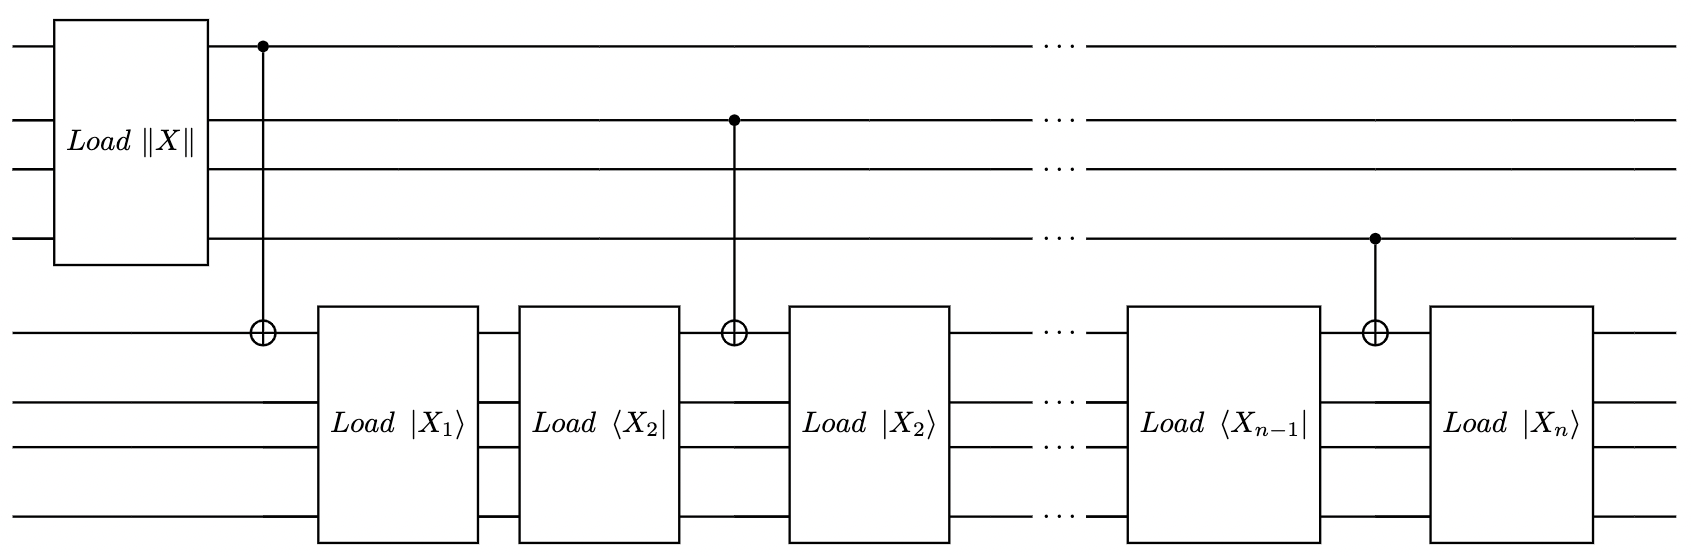

Each "Load" gate is a vector loader, which has several possible implementations:

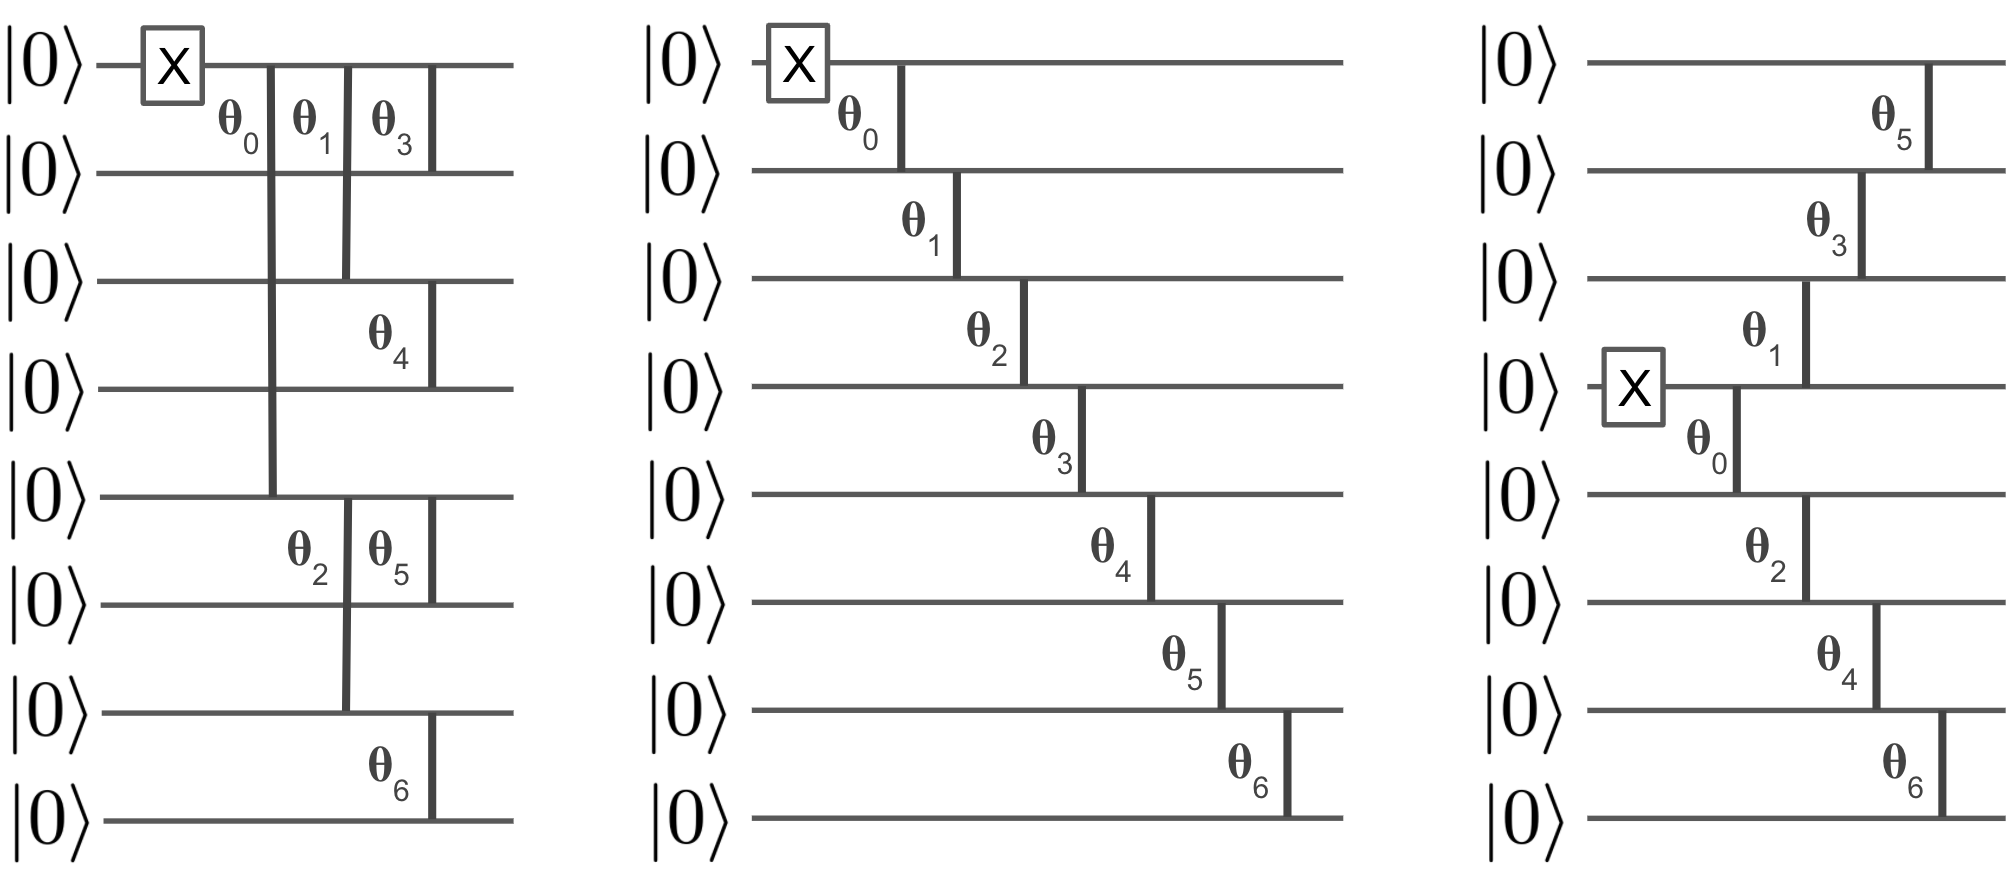

Here the vertical lines represent RBS (Reconfigurable Beam Splitter) gates, which are parametrised two-qubit gates given by the following unitary matrix:

$$RBS(\theta) = \begin{pmatrix}
1&0&0&0\\
0&\cos{\theta}&\sin{\theta}&0\\
0&-\sin{\theta}&\cos{\theta}&0\\
0&0&0&1
\end{pmatrix}$$

A nice application of these amplitude embeddings is that they facilitate much performing inner product computation with quantum circuits.

#### The complete architecture

Based on the ideas and concepts presented so far, we can now sketch a detailed architecture for a quantum vision transformer:

1. Input: An image is received as input and is divided into non-overlapping patches, similar to the classical vision transformer. Each patch is represented as a matrix.
2. Data Loading and Patch Embedding: Each matrix is loaded into a quantum circuit either using a matrix loading method described in El Amine Cherrat et al. [10], or some other type of quantum embedding layer. Depending on the method (whether the input embedding is trained or not), a patch embedding layer, like in the classical vision transformer, might need to be implemented. This can be achieved using layers like the PennyLane basic entangler layers, or more complex types of quantum layers.
4. Positional Encoding: Positional encoding, which is essential for capturing the spatial information of the input, can be added using a quantum layer that applies a position-dependent bias to the embeddings.
3. Quantum Self-Attention: After loading the patches and incorporating positional information, a quantum self-attention mechanism is applied. We discussed several methods earlier, some of them hybrid, and some fully quantum.
4. Quantum Feed-Forward Network: Following the self-attention step, a quantum version of the multi-layer perceptron (MLP) layer is applied, as in the original transformer architecture. This can be achieved using quantum entangling layers or other quantum layers that offer more expressive power and adaptability to the task at hand.
5. Layer Normalization and Residual Connections: To stabilize the learning process and improve convergence, layer normalization can be applied after each quantum self-attention and quantum feed-forward layer. Additionally, residual connections can be employed to facilitate gradient flow during training and mitigate the vanishing gradient problem. In the available research, I did not find these steps to be explored in the quantum realm.
6. Output: The output can be obtained using a classical layer with a softmax activation function for tasks like classification, or using other suitable activation functions depending on the problem being solved. Alternatively, some types of quantum nonlinearities, as further discussed in [10], can be employed to generate the final output directly from the quantum circuit.

The architectural choices for a quantum vision transformer are numerous, and it could be a valuable research project to combine and explore new ideas.

### References

1. [Ashish Vaswani et al. Attention Is All You Need (2017)](https://arxiv.org/abs/1706.03762)
2. [Alexey Dosovitskiy et al. An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale (2021)](https://arxiv.org/abs/2010.11929v2)
3. [Original Vision Transformer implementation (Google Research GitHub)](https://github.com/google-research/vision_transformer/blob/main/vit_jax/models_vit.py)
4. [PyTorch](https://pytorch.org/)
5. [Ray Tune: Scalable Hyperparameter Tuning](https://docs.ray.io/en/latest/tune/index.html)
6. [Stefan Falkner et al. BOHB: Robust and Efficient Hyperparameter Optimization at Scale (2018)](http://proceedings.mlr.press/v80/falkner18a.html)
7. [Riccardo Di Sipio et al. The Dawn of Quantum Natural Language Processing (2021)](https://arxiv.org/abs/2110.06510)
8. [Riccardo Di Sipio. Toward a Quantum Transformer (2021)](https://towardsdatascience.com/toward-a-quantum-transformer-a51566ed42c2)
9. [Guangxi Li et al. Quantum Self-Attention Neural Networks for Text Classification (2022)](https://arxiv.org/abs/2205.05625)
10. [El Amine Cherrat et al. Quantum Vision Transformers (2022)](https://arxiv.org/abs/2209.08167)
11. [Iordanis Kerenidis et al. q-means: A quantum algorithm for unsupervised machine learning (2018)](https://arxiv.org/abs/1812.03584)
12. [Ilya Tolstikhin et al. 
MLP-Mixer: An all-MLP Architecture for Vision (2021)](https://arxiv.org/abs/2105.01601)
13. [Iris Cong et al. Quantum Convolutional Neural Networks (2018)](https://arxiv.org/abs/1810.03787)
14. [Guillaume Verdon et al. Quantum Graph Neural Networks (2019)](https://arxiv.org/abs/1909.12264)
15. [Sonika Johri et al. Nearest Centroid Classification on a Trapped Ion Quantum Computer (2020)](https://arxiv.org/abs/2012.04145)
16. [Iordanis Kerenidis. Quantum Data Loader (2021) (patent application)](https://patents.google.com/patent/US20210319350A1)